# Introduction

In this notebook, we will load a bearing dataset (public dataset) available in the link below:

Link: [Bearing dataset](https://csegroups.case.edu/bearingdatacenter/pages/welcome-case-western-reserve-university-bearing-data-center-website)

This dataset contains time series for normal and faulty bearings. There are several faulty modes. We will use the three faulty modes for the drive end bearing fault data. These files are available at the GitHub repository (https://github.com/m-small/ITTC-masterclass) but the original files can also be dowloaded from here:

Links: https://csegroups.case.edu/bearingdatacenter/pages/normal-baseline-data and https://csegroups.case.edu/bearingdatacenter/pages/12k-drive-end-bearing-fault-data

### Setup

In [1]:
from utils import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ordpy
import networkx as nx
from tqdm import tqdm
import seaborn as sns

# the following to lines will tell to the python kernel to always update the kernel for every utils.py
# modification, without the need of restarting the kernel.
%load_ext autoreload
%autoreload 2

# using the 'inline' backend, your matplotlib graphs will be included in your notebook, next to the code
%matplotlib inline
#%matplotlib qt

plt.close('all') # close all figures (to make sure that memory is clean)

## Loading the Data

In [2]:
labels = ['Healthy', 'Inner Race fault', 'Ball fault', 'Outer race fault']
df = pd.DataFrame(columns=labels)

ts_len = 1100 #to allow a feasible computation time for practice, 
              #we can increase this number to get more samples from each class. 
df_healthy = pd.read_csv('./Bearing_healthy.csv')
df['Healthy'] = df_healthy.iloc[:ts_len,0]

df_f1 = pd.read_csv('./Bearing_fault_1.csv')
df['Inner Race fault'] = df_f1.iloc[:ts_len,0]

df_f2 = pd.read_csv('./Bearing_fault_2.csv')
df['Ball fault'] = df_f2.iloc[:ts_len,0]

df_f3 = pd.read_csv('./Bearing_fault_3.csv')
df['Outer race fault'] = df_f3.iloc[:ts_len,0]

#### Let's have a look at a snapshot of the time series

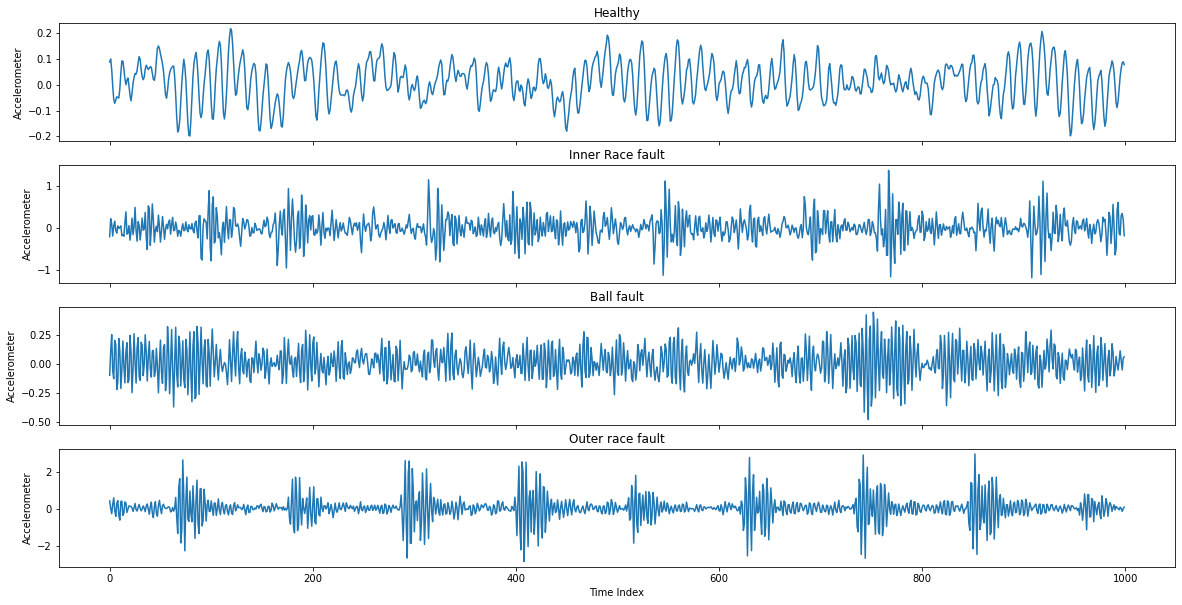

In [3]:
fig, axs = plt.subplots(nrows=4,ncols=1, figsize=(20,10), sharex=True)

for l,ax in zip(labels,axs):
    ax.plot(df[l][:1000]) 
    ax.set_title(l)
    ax.set_ylabel('Accelerometer')
ax.set_xlabel('Time Index')

plt.savefig('Bearing_data.pdf', bbox_inches='tight')

### Part 1: Creating ordinal partition networks and computing basic network properties.

We will create several samples representing the normal mode and each of the faulty mode. This will be done with a sliding window of length W across the time series. For each window, we will create a ordinal partitional network and compute several features from it to chatacterise its topology. 

Some of the measures we will compute are:
- average clustering coefficient
- transitivity
- average path length
- link density
- number of nodes
- average degree
- etc... (more options in utils.py)

There are parameters we need to define, for instance:
- the embedding dimension m
- the embedding lag tau (we will only use tau=1 in this notebook)
- the window size
- the sliding size (we will have overlapped consecutive windows, that is our, sliding size will be 1 - you can change that later)

Next, we will see compute the network properties for a W=1000 (`win_len`) and we will test several values of m (`all_ms`). We will keep tau=1 and we will move the window one point in time (maximum overlapping). 

This reference presents some approaches to define W generally:
de Mello, R. F., Vaz, Y., Grossi, C. H., & Bifet, A. (2019). On learning guarantees to unsupervised concept drift detection on data streams. Expert Systems with Applications, 117, 90-102.

In [29]:
win_len = 1000
all_ms = [2,3,4,5,6,7] #let's try several values for m

list_feat = ('av_clust_coeff', 'av_shortest_path_length', 'closeness_centrality', 
             'transitivity', 'n_self_loops', 'mean_cycle_length', 'n_cliques', 
             'net_inv_diam', 'n_nodes', 'av_degree', 'av_degree_centrality', 'density')

measures_network = {}
for m in tqdm(all_ms):
    df_h = get_net_properties_window(m,df[labels[0]],0,list_feat,win_len)
    df_f1 = get_net_properties_window(m,df[labels[1]],1,list_feat,win_len)
    df_f2 = get_net_properties_window(m,df[labels[2]],2,list_feat,win_len)
    df_f3 = get_net_properties_window(m,df[labels[3]],3,list_feat,win_len)
    
    measures_network[m] = pd.concat([df_h,df_f1,df_f2,df_f3],axis=0)

100%|██████████| 6/6 [10:59<00:00, 109.96s/it]


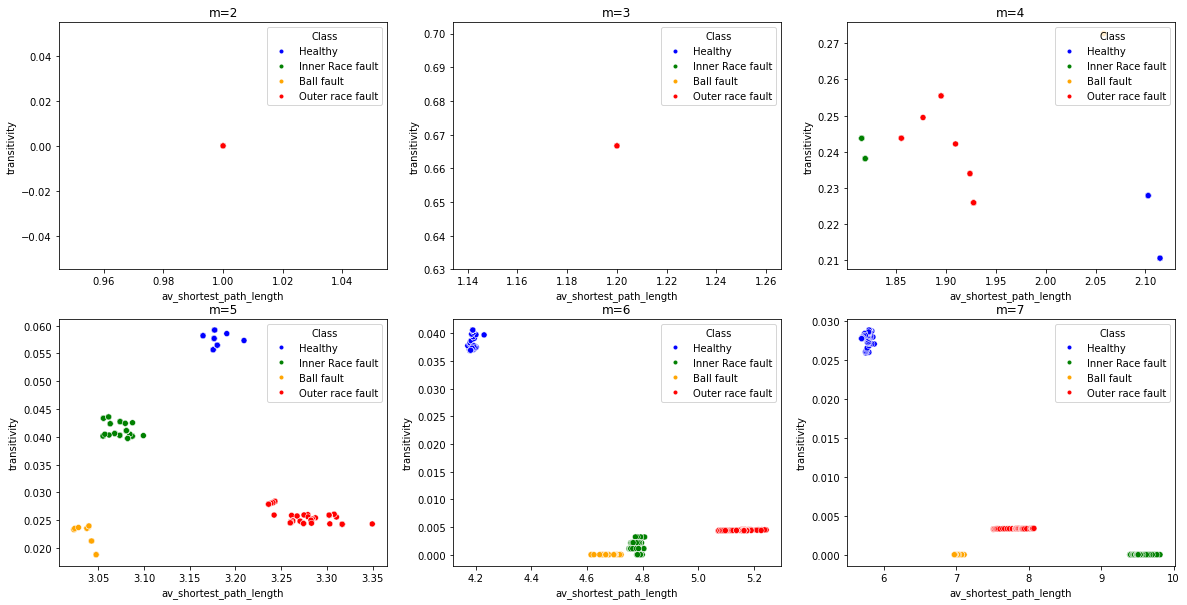

In [32]:
fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(20,10))

measure1 = 'av_shortest_path_length'
measure2 = 'transitivity'

color_dict = dict({0:'blue',
                   1:'green',
                   2: 'orange',
                   3: 'red'})
custom = []
for l, _ in enumerate(labels):
    custom.append(Line2D([], [], marker='.', color=color_dict[l], linestyle='None'))
        
i = 0
j = 0
for m in range(len(all_ms)):
    if j == 3:
        i += 1
        j = 0
    
    data = measures_network[all_ms[m]]
    sns.scatterplot(x=measure1,y=measure2,data=data, 
                    hue='Class', palette=color_dict, ax=axs[i,j])
    axs[i,j].set_title(f'm={all_ms[m]}')


    axs[i,j].legend(custom, labels, loc='upper right',title="Class",
                    fancybox=True)
        
    j += 1
    
plt.savefig('Window1000.pdf', bbox_inches='tight')

#### Looking at different cycles lengths of the different classes.

In [6]:
m = 5
for m in tqdm(all_ms):
    len_cycles_h, mean_cycle_length_h = get_cycles_distribution(m,df[labels[0]])
    len_cycles_f1, mean_cycle_length_f1 = get_cycles_distribution(m,df[labels[1]])
    len_cycles_f2, mean_cycle_length_f2 = get_cycles_distribution(m,df[labels[2]])
    len_cycles_f3, mean_cycle_length_f3 = get_cycles_distribution(m,df[labels[3]])

100%|██████████| 6/6 [00:00<00:00,  7.29it/s]


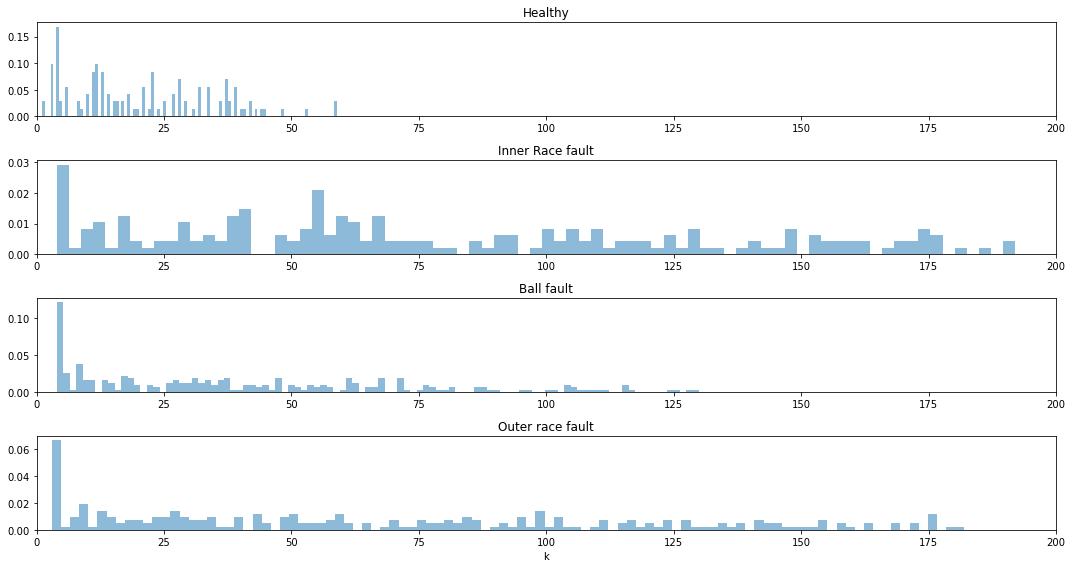

In [7]:
fig, axs = plt.subplots(nrows=4,ncols=1, figsize=(15,8))

axs[0].hist(len_cycles_h, bins=100, alpha=0.5, density=True)
axs[0].set_xlim([0, 200])
axs[0].set_title(labels[0])
axs[1].hist(len_cycles_f1, bins=100, alpha=0.5, density=True)
axs[1].set_xlim([0, 200])
axs[1].set_title(labels[1])
axs[2].hist(len_cycles_f2, bins=100, alpha=0.5, density=True)
axs[2].set_xlim([0, 200])
axs[2].set_title(labels[2])
axs[3].hist(len_cycles_f3, bins=100, alpha=0.5, density=True)
axs[3].set_xlim([0, 200])
axs[3].set_title(labels[3])
axs[3].set_xlabel('k')

plt.tight_layout()

#### Proposed exercises:


1) Try different combinations of features. Will all them work well to separate the different classes? 

2) What if we choose to use a smaller W, let's say, W=400? How would be the behavior of the different values of m? 

3) Plot the degree distribution of the different classes? We use this information to distinguish them?  

4) We have used undirected and unweighted networks so far. Would we get better results if we incorporate directionality and weights in the connections? Try it for a couple of features. You will need to modify slighly the function get_net_properties_window in ultils.py.

### Part 2: One-Class classification with AutoEncoders

Let's combine all network properties in a ML approach. We will exemplify here a one-class classification with autoencoders. For that, we will train the model to output the normal state of the system, and track the error prediction as we input to the trained model samples of faulty behavior. 

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from sklearn.model_selection import KFold

In [9]:
ts_len = 100000

df_normal = pd.read_csv('./Bearing_healthy.csv')
df_normal = df_normal.iloc[:ts_len,0]

#### Computing network topological properties as before

In [10]:
win_len = 1000
m = 4 #using only one m

#getting features dataframe for normal data
label=0
measures_network_normal = get_net_properties_window(m,df_normal,label,list_feat,win_len)

In [11]:
# We will use 80% of the data for training and 20% for testing
dataset = measures_network_normal
x_train, y_train, x_test, y_test = train_test_split(dataset,train_size=0.8)

#### Training the AutoEncoder

In [31]:
use_CV = True
n_neurons = 10#df_train.shape[1]-10

if(not use_CV):
    inputs = keras.Input(shape=(x_train.shape[1],))
    x = keras.layers.Dense(n_neurons)(inputs)
    x = LeakyReLU(alpha=0.3)(x)

    branchA = layers.Dense(n_neurons)(x)
    branchA = LeakyReLU(alpha=0.3)(branchA)

    outputs = layers.Dense(x_train.shape[1])(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="one_class_model")

    #modely = keras.Model(inputs=inputs, outputs=y, name="one_class_modely")
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="mse")
    history = fit_model(model,x_train)
else:
    
    inputs = keras.Input(shape=(x_train.shape[1],))
    x = keras.layers.Dense(n_neurons)(inputs)
    x = LeakyReLU(alpha=0.3)(x)
    
    branchA = keras.layers.Dense(n_neurons)(x)
    branchA = LeakyReLU(alpha=0.3)(branchA)

    outputs = keras.layers.Dense(x_train.shape[1])(branchA)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="one_class_model")
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    
    kfold = KFold(n_splits=10, shuffle=True)
    cvscores = []
    val_mae_loss = 10
    while(val_mae_loss>0.001):
        for train, test in kfold.split(x_train):
        
            try: 
                model = load_model(weights_path, compile=True)

            except Exception as OSError:
                pass
        
            val_data = x_train.iloc[test,:]
            train_data = x_train.iloc[train,:]
            history = model.fit(train_data, train_data)

            x_val_pred = model.predict(val_data)
            val_mae_loss = np.mean(np.mean(np.power(x_val_pred - val_data,2), axis=1))
            cvscores.append(val_mae_loss)

2228/2228 [==============================] - 2s 682us/step - loss: 4.7828e-04


Let's see the error in the test set

In [14]:
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.mean(np.power(x_test_pred - x_test,2), axis=1))
print(f'Mean Absolute Error: {test_mae_loss}')

Mean Absolute Error: 0.0010527223879168185


#### Now we load some data which has a smooth transition from normal to faulty

In [15]:
#For other faulty choose from:
#Bearing_healthy_to_fault_1.csv
#Bearing_healthy_to_fault_2.csv

df_normal_2_faulty = pd.read_csv('./Bearing_healthy_to_fault_2.csv')
df_normal_2_faulty = df_normal_2_faulty.iloc[:,0]

#### And compute the network features for the faulty mode

In [16]:
measures_network_normal_2_faulty = get_net_properties_window(m,df_normal_2_faulty,label,list_feat,win_len)

Now we can input the faulty data to the trained model (that only knows the normal data) and track the prediction error as the dynamics of the time series changes, reflecing the transition from normal state to faulty. 

In [17]:
data = measures_network_normal_2_faulty
data = data.iloc[:,:-1] #we dont need the label here
n_features = np.shape(data)[1]

test_mae_loss = np.zeros((len(data,)))
for i in tqdm(range(len(data))):
    x_test = data.iloc[i,:]
    x_test = x_test.values.reshape((1, n_features))
    x_test_pred = model.predict(x_test)
    test_mae_loss[i] = np.mean(np.power(x_test_pred - x_test,2), axis=1)

100%|██████████| 29000/29000 [13:25<00:00, 36.00it/s]


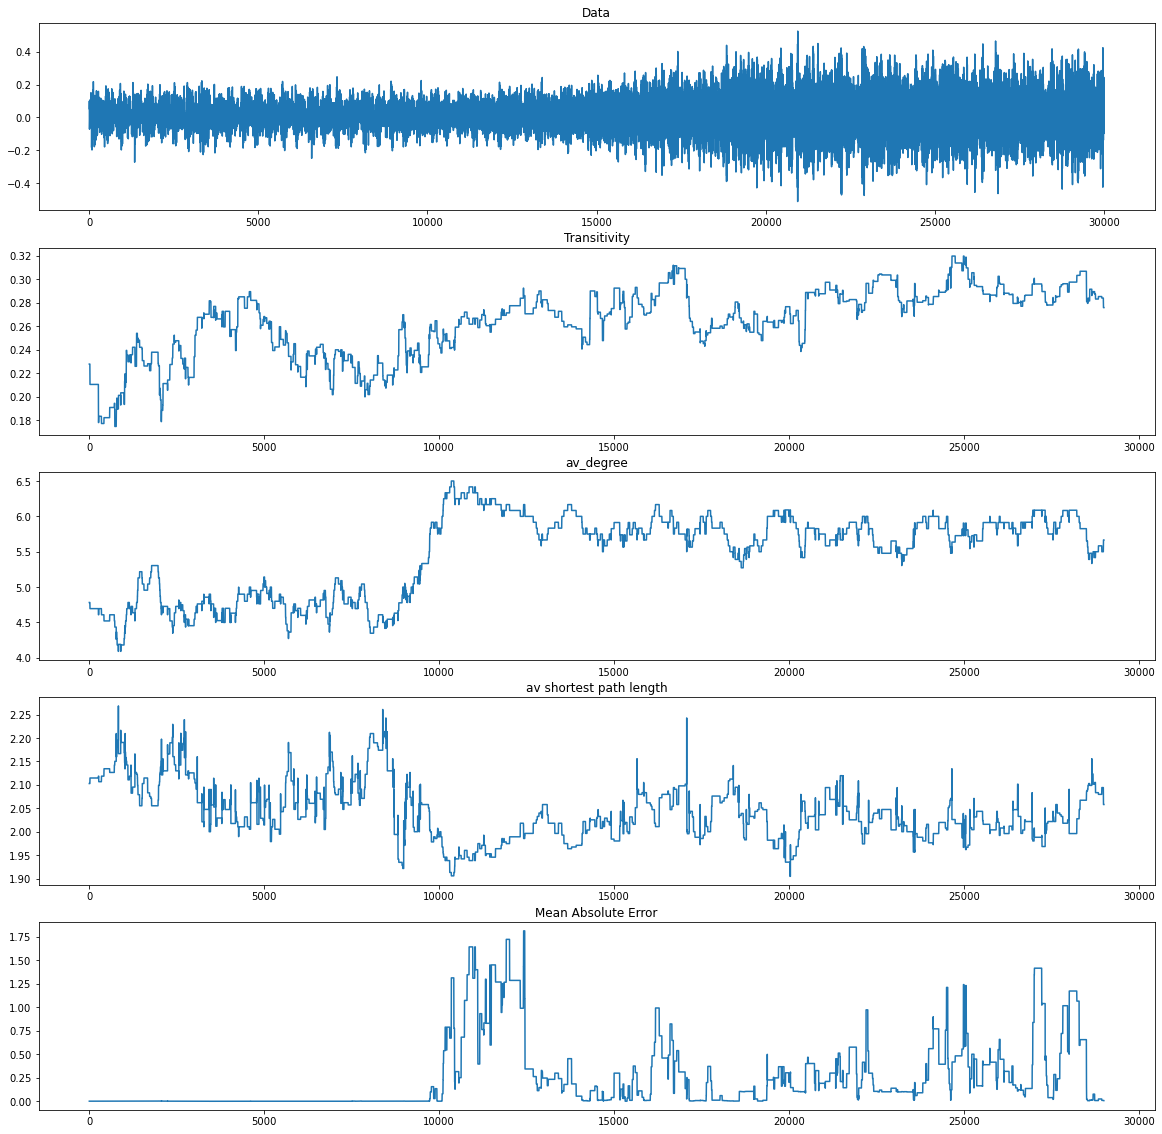

In [26]:
fig, axs = plt.subplots(nrows=5,ncols=1, figsize=(20,20))

axs[0].plot(df_normal_2_faulty)
axs[0].set_title('Data')
axs[1].plot(data['transitivity'])
axs[1].set_title('Transitivity')
axs[2].plot(data['av_degree'])
axs[2].set_title('Average Degree')
axs[3].plot(data['av_shortest_path_length'])
axs[3].set_title('Mean shortest path length')
axs[4].plot(test_mae_loss)
axs[4].set_title('Mean Absolute Error');

#### Proposed exercises:

1) Try other network properties. Has any of the property worked well by itself to capture the dynamical changes in the data?

2) Can you get good results for the other falty modes too?

3) Try the approach for different values of m and window size. Can the change in the dynamics be detected ealier?

4) Substitute the AutoEncoder for your favorite ML algorithm and try the approach with the other faulty modes. What are the most relevant network features in this case? Are different network properties relevant to detect different faulty modes? 